# Quantile Regression

To demonstrate the effect of different composite gradients on the speed of convergence of Hamiltonian Monte Carlo we fit a quantile regression, using the following model suggested by Fasiolo et al. (2016) and regularizing using the bridge estimator of Park and Casella (2008). Given a set of observations $\{(x_i,y_i)\}_{i=1}^n$, the goal is to estimate the $\tau$th quantile of the conditional distribution of $y|x$.  If $F(y|x)$ denotes the cumulative distribution function of $y$ conditioned on $x$, then this can be written

\begin{equation}
\mu(x) = F_{Y|X}^{-1}(\tau).
\end{equation}

Typically it is assumed that $\mu(x_i)=\sum_{j=1}^d x_{ij}\beta_j$, where each $\beta_j$ is a real-valued coefficient to be estimated.  We therefore write $\mu(x)=\mu(x,\beta)$ to indicate that the quantile estimator depends on $\beta$.  The resulting potential takes the form

\begin{equation}
U(\beta) = \sum_{i=1}^n L_\tau(\beta,x_i,y_i) + \lambda \sum_{j=1}^d |\beta_j|^q,
\end{equation}

for some choice $1 < q < 2$.  Here $L_\tau(\beta,x,y)$ is a smoothed version of the *pinball* loss function.  Setting $z = (y-\mu(x,\beta))/\sigma$, this is given by

\begin{equation}
L_\tau(\beta,x,y) = (\tau-1)\left\{ \frac{y-\mu(x,\beta)}{\sigma} \right\} 
+ \xi \log \left[ 1+ \exp\left\{ \frac{y-\mu(x,\beta)}{\sigma} \right\} \right]
+ \xi \sigma \text{Beta}[\xi(1-\tau),\xi\tau].
\end{equation}

where $\xi \to 0$ gives the non-differentiable pinball loss function, but for any $\xi>0$ this is a smooth function.  The scale parameter $\sigma$ is known as the learning rate.  The regularizer $\lambda>0$ is an inverse scale parameter for the prior.  The partial derivative of the potential with respect to each $\beta_j$ is

\begin{equation}
\partial_j U(\beta) = \frac{1-\tau}{\sigma} \sum_{i=1}^n x_{ij} + \xi \sum_{i=1}^n \frac{ \exp\left\{ \frac{y-\mu(x,\beta)}{\sigma} \right\} }{ 1 + \exp\left\{ \frac{y-\mu(x,\beta)}{\sigma} \right\} } x_{ij} + q\lambda\text{sgn}(\beta_j)|\beta_j|^{q-1}.
\end{equation}

In the numerical implementation care must be taken to ensure that the logistic functions are calculated in a numerically stable way.

In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

# specific functions
import HMC as h
from k_energies import *
import MC_diag as d

In [2]:
# Define the potential class for the quantile regression model.

# Beta function
import math
def Beta_func(a,b):
    '''uses gamma function or inbuilt math.gamma() to compute values of beta function'''
    Beta = math.gamma(a)*math.gamma(b)/math.gamma(a+b)
    return Beta

# numerically stable logistic function
def logistic_func(x):  
    '''computes logistic function in numerically stable way'''
    return np.exp(-np.logaddexp(0, -x))

# Potential function for quantile regression (with sigma fixed)
class Quantile:
    """Quantile regression"""
    def __init__(self, tau, sigma, l, B, y, xi = 0.1, q = 2):
        self.tau = tau # quantile
        self.sigma = sigma # learning rate / observation noise
        self.xi = xi # pinball smoother
        self.l = l # regulariser
        self.q = q # prior power
        self.B = B # design matrix
        self.y = y # response
        
    def value(self, beta):
        # fixed parameters
        tau = self.tau
        sigma = self.sigma
        xi = self.xi
        l = self.l
        q = self.q
        B = self.B
        y = self.y
        
        z1 = (y - np.inner(B,beta))/sigma
        z2 = (y - np.inner(B,beta))/(xi*sigma)
        
        L_vec = (tau - 1)*z1 + xi*np.logaddexp(0,z2) + np.log(xi*sigma*Beta_func(xi*(1-tau), xi*tau))
        prior_vec = np.absolute(beta) ** q
        U = sum(L_vec) + l*sum(prior_vec)
        return U
    
    def grad(self, beta):
        # fixed parameters
        tau = self.tau
        sigma = self.sigma
        xi = self.xi
        l = self.l
        q = self.q
        B = self.B
        y = self.y
        
        z2 = (y - np.inner(B,beta))/(xi*sigma)
        
        B_csum = np.sum(B, axis=0)
        prior_grad = q*l*np.sign(beta)*np.absolute(beta)**(q-1)
        logistic_term = logistic_func(z2)
        
        midterm = np.zeros(len(beta))
        for j in xrange(len(beta)):
            midterm[j] = np.inner(logistic_term,B[:,j])
        
        grad = (1-tau)/sigma * B_csum + 1/sigma * midterm + prior_grad
        # insert middle term refinement
        
        return grad

22.5
[ 22.5]


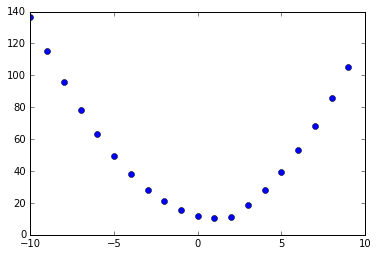

In [3]:
# A test run with one dimensional data
x = np.ones((5,1))
y = (2 * x).ravel()
U = Quantile(tau = 0.5, sigma = 1, l = 1, B = x, y = y)

beta_opt = np.array([1.0])
beta_sub = np.array([-1.0])

beta_test = np.array([10.0])

print (U.value(beta_test + 0.01) - U.value(beta_test - 0.01)) / 0.02
print U.grad(beta_test) # derivatives seem to agree with finite differences
beta_seq = range(-10,10)
U_seq = []
for i in xrange(len(beta_seq)):
    U_seq.append(U.value([beta_seq[i]]))
plt.plot(beta_seq, U_seq, 'o');

53.3203626329
[ 6.01352735 -9.76629119]


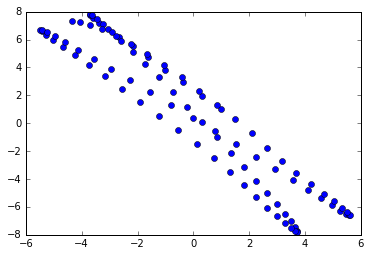

In [4]:
# Simple quantile regression data set
x1 = np.random.normal(size = 20)
x2 = np.random.normal(size = 20)
y_test = 2*x1 -2*x2 + 0.1*np.random.normal(size = 20)

X_test = np.empty((20,2))
X_test[:,0] = x1
X_test[:,1] = x2

# Assessing derivatives
U = Quantile(tau = 0.5, sigma = 1, l = 1, B = X_test, y = y_test)
K_g = Gauss()

start_vec = np.ones(2)

print U.value(start_vec)
print U.grad(start_vec)
samples = h.flow_verb(np.zeros(2), np.ones(2), U.grad, K_g.grad, L = 100, e = 0.1)
plt.plot(samples[2,:],samples[3,:],'o');

All seems to be in order so we can proceed with the sampling.

## Starting the sampler in the tails

Here we illustrate how appropriate tuning of the composite gradient helps the sampler.  We first set a Gaussian prior, and then a heavier-tailed prior, to show how the optimal choice differs in these two instances.

In [5]:
# MCMC run with Gaussian priors for the coefficients
U_q2 = Quantile(tau = 0.75, sigma = 1, l = 1, B = X_test, y = y_test)
K_g = Gauss()
K_l = Laplace()
K_t8 = Student(8)
K_t4 = Student(4)

start_vec = 200*np.ones(2)
nits = 10000

samples_g_q2 = h.HMC(nits, start_vec, U_q2, K_g, L = 1, e = 0.05) #, BurnIn = 500)
samples_l_q2 = h.HMC(nits, start_vec, U_q2, K_l, L = 1, e = 0.05) #, BurnIn = 500)
samples_t8_q2 = h.HMC(nits, start_vec, U_q2, K_t8, L = 1, e = 0.05) #, BurnIn = 500)
samples_t4_q2 = h.HMC(nits, start_vec, U_q2, K_t4, L = 1, e = 0.05) #, BurnIn = 500)

x_samples_g_q2 = samples_g_q2['x']
x_samples_l_q2 = samples_l_q2['x']
x_samples_t8_q2 = samples_t8_q2['x']
x_samples_t4_q2 = samples_t4_q2['x']

Acceptance rate: 0.734800
LF Steps: 1, Step-size: 0.050
Numerical divergences: 0
Acceptance rate: 0.804600
LF Steps: 1, Step-size: 0.050
Numerical divergences: 0
Acceptance rate: 0.802100
LF Steps: 1, Step-size: 0.050
Numerical divergences: 0
Acceptance rate: 0.716200
LF Steps: 1, Step-size: 0.050
Numerical divergences: 0


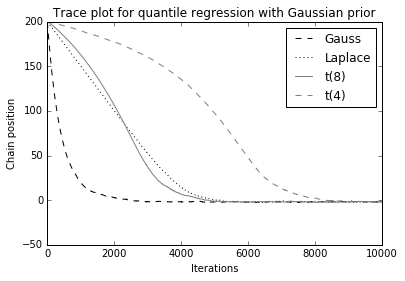

In [6]:
# plots in separate window so they can be executed without re-running the chains
plt.plot(x_samples_g_q2[1,:], '--', color = '0', label = "Gauss")
plt.plot(x_samples_l_q2[1,:], ':', color = '0', label = "Laplace")
plt.plot(x_samples_t8_q2[1,:], '-', color='0.5', label = "t(8)")
plt.plot(x_samples_t4_q2[1,:], '--', color='0.5', label = "t(4)")

plt.xlabel('Iterations')
plt.ylabel('Chain position')
plt.title('Trace plot for quantile regression with Gaussian prior');
plt.legend(loc=1);

We can clearly see that the Gaussian choice, which is optimal here, provides the fastest convergence towards a high-probability region at equilibrium.  The heavy-tailed choices display the negligible moves property, moving very small amounts initially before picking up speed when the chain is closer to equilibrium.

In [7]:
# MCMC run with Bridge regression prior, q = 1.5.  Now a cubic family choice should be more desirable.
U_q15 = Quantile(tau = 0.75, sigma = 1, l = 1, B = X_test, y = y_test, q = 1.5)

K_g = Gauss()
K_l = Laplace()
K_PE3 = PE_family(3)
K_t4 = Student(4)

start_vec = 500*np.ones(2)
nits = 20000

samples_g_q15 = h.HMC(nits, start_vec, U_q15, K_g, L = 1, e = 0.06) #, BurnIn = 500)
samples_l_q15 = h.HMC(nits, start_vec, U_q15, K_l, L = 1, e = 0.06) #, BurnIn = 500)
samples_PE3_q15 = h.HMC(nits, start_vec, U_q15, K_PE3, L = 1, e = 0.06) #, BurnIn = 500)
samples_t4_q15 = h.HMC(nits, start_vec, U_q15, K_t4, L = 1, e = 0.06) #, BurnIn = 500)

x_samples_g_q15 = samples_g_q15['x']
x_samples_l_q15 = samples_l_q15['x']
x_samples_PE3_q15 = samples_PE3_q15['x']
x_samples_t4_q15 = samples_t4_q15['x']


Acceptance rate: 0.831850
LF Steps: 1, Step-size: 0.060
Numerical divergences: 0
Acceptance rate: 0.826950
LF Steps: 1, Step-size: 0.060
Numerical divergences: 0
Acceptance rate: 0.806100
LF Steps: 1, Step-size: 0.060
Numerical divergences: 0
Acceptance rate: 0.863300
LF Steps: 1, Step-size: 0.060
Numerical divergences: 0


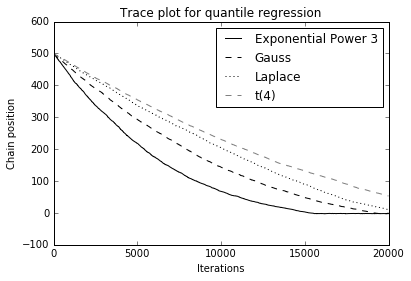

In [8]:
# plots in separate window so they can be executed without re-running the chains
plt.plot(x_samples_PE3_q15[1,:], '-', color = '0', label = "Exponential Power 3")
plt.plot(x_samples_g_q15[1,:], '--', color = '0', label = "Gauss")
plt.plot(x_samples_l_q15[1,:], ':', color = '0', label = "Laplace")
plt.plot(x_samples_t4_q15[1,:], '--', color = '0.5', label = "t(4)")

plt.xlabel('Iterations')
plt.ylabel('Chain position')
plt.title('Trace plot for quantile regression');
plt.legend(loc=1);

In this case the faster growing kinetic energy provides faster convergence to the centre of the space.  Here the effects when comparing the Laplacian and t-distributed kinetic energies are not so pronounced because the potential growth isn't as fast, meaning the negligible moves property is not as pronounced.

## Sampling in the centre of the space

Acceptance rate: 0.703500
LF Steps: 1, Step-size: 0.050
Numerical divergences: 0
Acceptance rate: 0.709150
LF Steps: 1, Step-size: 0.050
Numerical divergences: 0
Acceptance rate: 0.724550
LF Steps: 1, Step-size: 0.050
Numerical divergences: 0
Acceptance rate: 0.739700
LF Steps: 1, Step-size: 0.050
Numerical divergences: 0
[1] 120.082

[1] 162.602

[1] 106.4344

[1] 133.0704



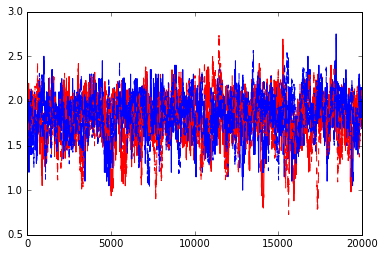

In [9]:
# MCMC run with Gaussian priors for the coefficients
U_q2 = Quantile(tau = 0.75, sigma = 1, l = 1, B = X_test, y = y_test)
K_g = Gauss()
K_l = Laplace()
K_t8 = Student(8)
K_t4 = Student(4)

start_vec = np.array([2,-2])
nits = 20000

samples_g_q2_centre = h.HMC(nits, start_vec, U_q2, K_g, L = 1, e = 0.05) #, BurnIn = 500)
samples_l_q2_centre = h.HMC(nits, start_vec, U_q2, K_l, L = 1, e = 0.05) #, BurnIn = 500)
samples_t8_q2_centre = h.HMC(nits, start_vec, U_q2, K_t8, L = 1, e = 0.05) #, BurnIn = 500)
samples_t4_q2_centre = h.HMC(nits, start_vec, U_q2, K_t4, L = 1, e = 0.05) #, BurnIn = 500)

x_samples_g_q2_centre = samples_g_q2_centre['x']
x_samples_l_q2_centre = samples_l_q2_centre['x']
x_samples_t8_q2_centre = samples_t8_q2_centre['x']
x_samples_t4_q2_centre = samples_t4_q2_centre['x']

print d.ess(x_samples_g_q2_centre[0,:])
print d.ess(x_samples_l_q2_centre[0,:])
print d.ess(x_samples_t8_q2_centre[0,:])
print d.ess(x_samples_t4_q2_centre[0,:])

plt.plot(x_samples_g_q2_centre[0,:], 'r-')
plt.plot(x_samples_l_q2_centre[0,:], 'b-')
plt.plot(x_samples_t8_q2_centre[0,:], 'r--')
plt.plot(x_samples_t4_q2_centre[0,:], 'b--');

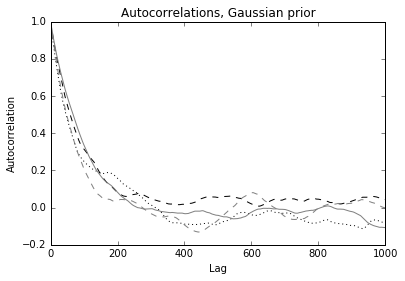

In [10]:
# autocorrelation plots, Gaussian prior
from statsmodels.tsa.stattools import acf
acf_g_q2 = acf(x_samples_g_q2_centre[0,:], nlags=1000)
acf_l_q2 = acf(x_samples_l_q2_centre[0,:], nlags=1000)
acf_t8_q2 = acf(x_samples_t8_q2_centre[0,:], nlags=1000)
acf_t4_q2 = acf(x_samples_t4_q2_centre[0,:], nlags=1000)

plt.plot(acf_g_q2, '--', color = '0')
plt.plot(acf_l_q2, ':', color = '0')
plt.plot(acf_t8_q2, '-', color = '0.5')
plt.plot(acf_t4_q2, '--', color = '0.5');

plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelations, Gaussian prior');

Acceptance rate: 0.702450
LF Steps: 1, Step-size: 0.060
Numerical divergences: 0
Acceptance rate: 0.682100
LF Steps: 1, Step-size: 0.060
Numerical divergences: 0
Acceptance rate: 0.682250
LF Steps: 1, Step-size: 0.060
Numerical divergences: 0
Acceptance rate: 0.714100
LF Steps: 1, Step-size: 0.060
Numerical divergences: 0
[1] 221.2105

[1] 233.622

[1] 143.7314

[1] 182.777



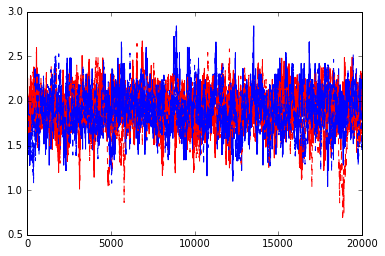

In [11]:
# MCMC run with Bridge regression prior, q = 1.5.  Now a cubic family choice should be more desirable.
U_q15 = Quantile(tau = 0.75, sigma = 1, l = 1, B = X_test, y = y_test, q = 1.5)

K_g = Gauss()
K_l = Laplace()
K_PE3 = PE_family(3)
K_t4 = Student(4)

start_vec = np.array([2,-2])
nits = 20000

samples_g_q15_centre = h.HMC(nits, start_vec, U_q15, K_g, L = 1, e = 0.06) #, BurnIn = 500)
samples_l_q15_centre = h.HMC(nits, start_vec, U_q15, K_l, L = 1, e = 0.06) #, BurnIn = 500)
samples_PE3_q15_centre = h.HMC(nits, start_vec, U_q15, K_PE3, L = 1, e = 0.06) #, BurnIn = 500)
samples_t4_q15_centre = h.HMC(nits, start_vec, U_q15, K_t4, L = 1, e = 0.06) #, BurnIn = 500)

x_samples_g_q15_centre = samples_g_q15_centre['x']
x_samples_l_q15_centre = samples_l_q15_centre['x']
x_samples_PE3_q15_centre = samples_PE3_q15_centre['x']
x_samples_t4_q15_centre = samples_t4_q15_centre['x']

print d.ess(x_samples_g_q15_centre[0,:])
print d.ess(x_samples_l_q15_centre[0,:])
print d.ess(x_samples_PE3_q15_centre[0,:])
print d.ess(x_samples_t4_q15_centre[0,:])

plt.plot(x_samples_g_q15_centre[0,:], 'r-')
plt.plot(x_samples_l_q15_centre[0,:], 'b-')
plt.plot(x_samples_PE3_q15_centre[0,:], 'r--')
plt.plot(x_samples_t4_q15_centre[0,:], 'b--');

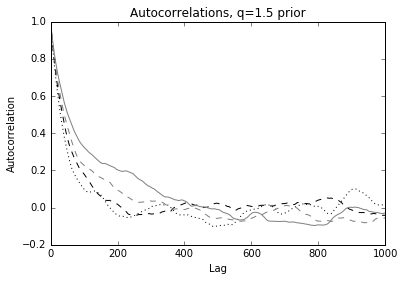

In [12]:
# autocorrelation plots, q = 1.5 prior
acf_g_q15 = acf(x_samples_g_q15_centre[0,:], nlags=1000)
acf_l_q15 = acf(x_samples_l_q15_centre[0,:], nlags=1000)
acf_PE3_q15 = acf(x_samples_PE3_q15_centre[0,:], nlags=1000)
acf_t4_q15 = acf(x_samples_t4_q15_centre[0,:], nlags=1000)

plt.plot(acf_g_q15, '--', color = '0')
plt.plot(acf_l_q15, ':', color = '0')
plt.plot(acf_PE3_q15, '-', color = '0.5')
plt.plot(acf_t4_q15, '--', color = '0.5');

plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelations, q=1.5 prior');

## Plotting everything together

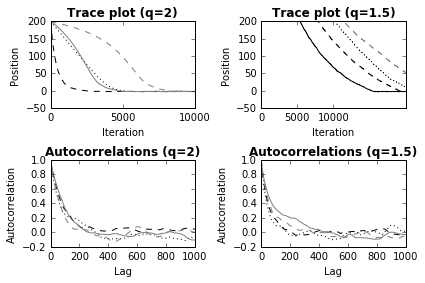

In [13]:
# All four plots in one window would be ideal!
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

# first subplot
ax1.plot(x_samples_g_q2[1,:], '--', color = '0', label = "Gauss")
ax1.plot(x_samples_l_q2[1,:], ':', color = '0', label = "Laplace")
ax1.plot(x_samples_t8_q2[1,:], '-', color='0.5', label = "t(8)")
ax1.plot(x_samples_t4_q2[1,:], '--', color='0.5', label = "t(4)")

ax1.set_title('Trace plot (q=2)', fontweight='bold')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Position')
ax1.set_xticks([0,5000,10000])

# second subplot
ax2.plot(x_samples_PE3_q15[1,:], '-', color = '0', label = "Exponential Power 3")
ax2.plot(x_samples_g_q15[1,:], '--', color = '0', label = "Gauss")
ax2.plot(x_samples_l_q15[1,:], ':', color = '0', label = "Laplace")
ax2.plot(x_samples_t4_q15[1,:], '--', color = '0.5', label = "t(4)");

ax2.set_title('Trace plot (q=1.5)', fontweight='bold')
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Position')
ax2.set_xticks([0,5000,10000])
ax2.set_ylim([-50,200])

# third subplot
ax3.plot(acf_g_q2, '--', color = '0')
ax3.plot(acf_l_q2, ':', color = '0')
ax3.plot(acf_t8_q2, '-', color = '0.5')
ax3.plot(acf_t4_q2, '--', color = '0.5');

ax3.set_xlabel('Lag')
ax3.set_ylabel('Autocorrelation')
ax3.set_title('Autocorrelations (q=2)', fontweight='bold');

# fourth subplot
ax4.plot(acf_g_q15, '--', color = '0')
ax4.plot(acf_l_q15, ':', color = '0')
ax4.plot(acf_PE3_q15, '-', color = '0.5')
ax4.plot(acf_t4_q15, '--', color = '0.5');

ax4.set_xlabel('Lag')
ax4.set_ylabel('Autocorrelation')
ax4.set_title('Autocorrelations (q=1.5)', fontweight='bold');

plt.tight_layout();

plt.savefig('Qreg.eps')

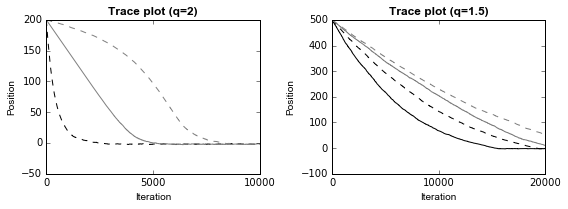

In [14]:
# And plot with just the two trace plots, using Arial font as in R
# All four plots in one window would be ideal!
from pylab import rcParams
rcParams['figure.figsize'] = 8, 3

f, (ax1, ax2) = plt.subplots(1, 2)

arialfont = {'fontname':'Arial'}

# first subplot
ax1.plot(x_samples_g_q2[1,:], '--', color = '0', label = "Gauss")
ax1.plot(x_samples_l_q2[1,:], '-', color = '0.5', label = "Laplace")
#ax1.plot(x_samples_t8_q2[1,:], '-', color='0.5', label = "t(8)")
ax1.plot(x_samples_t4_q2[1,:], '--', color='0.5', label = "t(4)")

ax1.set_title('Trace plot (q=2)', fontweight='bold', **arialfont)
ax1.set_xlabel('Iteration', **arialfont)
ax1.set_ylabel('Position', **arialfont)
ax1.set_xticks([0,5000,10000])

# second subplot
ax2.plot(x_samples_PE3_q15[1,:], '-', color = '0', label = "Exponential Power 3")
ax2.plot(x_samples_g_q15[1,:], '--', color = '0', label = "Gauss")
ax2.plot(x_samples_l_q15[1,:], '-', color = '0.5', label = "Laplace")
ax2.plot(x_samples_t4_q15[1,:], '--', color = '0.5', label = "t(4)");

ax2.set_title('Trace plot (q=1.5)', fontweight='bold', **arialfont)
ax2.set_xlabel('Iteration', **arialfont)
ax2.set_ylabel('Position', **arialfont)
ax2.set_xticks([0,10000,20000])
ax2.set_ylim([-100,500])

plt.tight_layout();

plt.savefig('Qreg2.eps')